In [59]:
from __future__ import print_function
from ase.io import *
import numpy as np
from ase.units import Bohr
from kqeq import kernel_qeq, get_dipoles
from kqeq.kernel import kernel
import random

In [94]:
# Get data
mols = read("data/LiH_dipoles.xyz@:",format='extxyz')
indices = [i for i in range(len(mols))]
random.shuffle(indices)

mols_train = []
mols_valid = []

for i in range(len(mols)):
    if i < 200:
        mols_train.append(mols[indices[i]])
    else:
        mols_valid.append(mols[indices[i]])
        
#mols_train = read("data/LiH_dipoles.xyz@:200",format='extxyz')
#mols_valid = read("data/LiH_dipoles.xyz@200:",format='extxyz')

In [63]:
desdict = {"nmax" : 6,
           "lmax" : 3,
           "rcut" : 3,
           "sigma": 0.2,
           "periodic": False}

Kernel = kernel(Kernel='SOAP',Descriptor='SOAP',descriptor_dict=desdict)


In [80]:
# Set up and initialize a kqeq model with the training set and the choosen kernel

my_kqeq = kernel_qeq(training_set=mols_train,Kernel=Kernel,scale_atsize=0.5,calculate_kernel_forces=True,include_LJ=False)

In [81]:
# Train a model with a given regularization parameter
my_kqeq.train(lambda_reg=1.0)

# Predict dipole moments for training and validation set
dipoles_v, charges_v, enegs_v = my_kqeq.predict(mols_valid)
dipoles_t, charges_t, enegs_t = my_kqeq.predict(mols_train)

# Get reference values from atoms objects
dipoles_v_ref = get_dipoles(mols_valid)
dipoles_t_ref = get_dipoles(mols_train)

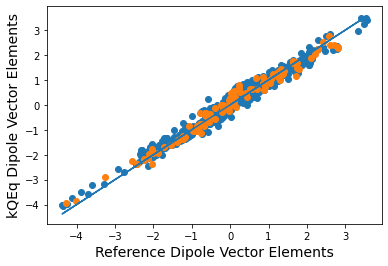

In [82]:
# Plot the results
import matplotlib.pyplot as plt
plt.scatter(dipoles_t_ref,dipoles_t)
plt.scatter(dipoles_v_ref,dipoles_v)
plt.plot(dipoles_t_ref,dipoles_t_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()


In [83]:
results                       = my_kqeq.calculate(mols_train[1])
f = results['forces']
print(f)

[[  0.34063686  12.68870023  -2.9560347 ]
 [ -0.34063686 -12.68870023   2.9560347 ]]


In [84]:
def num_grad(mol,my_kqeq,h=0.0001,direction=0,iatom=0):
    tmpmol = mol.copy()
    pos = tmpmol.get_positions()
    pos[iatom][direction] += h
    tmpmol.set_positions(pos)
    res = my_kqeq.calculate(tmpmol)
    Eplus = res['energy']
    pos[iatom][direction] += -2.0*h
    tmpmol.set_positions(pos)
    res = my_kqeq.calculate(tmpmol)
    Eminus = res['energy']
    pos[iatom][direction] += h
    tmpmol.set_positions(pos)
    return (Eplus-Eminus)/(2.0*h)

def num_grads(mol,my_kqeq,h=0.0001):
    f = np.zeros((len(mol),3))
    for i in range(len(mol)):
        for direction in range(3):
            f[i,direction] = num_grad(mol,my_kqeq,h=h,direction=direction,iatom=i)
    return f
        

In [85]:
f_num = num_grads(mols_train[1],my_kqeq)

In [86]:
f_num/f

array([[-1.00000042, -1.00000014, -1.00000038],
       [-1.00000042, -1.00000014, -1.00000039]])

In [87]:
print(f_num)

[[ -0.340637   -12.68870197   2.95603582]
 [  0.340637    12.68870196  -2.95603584]]


In [97]:
mol = mols_train[150]
view(mol)

In [98]:
from kqeq.calculator import Kqeq
calc = Kqeq(my_kqeq)
mol.set_calculator(calc)
mol.get_forces()

array([[-0.97328447, -0.79543862, -0.26691977],
       [-0.2697268 , -0.14431774, -0.16681788],
       [-0.63902157, -1.50733995,  1.358427  ],
       [ 0.55802111, -0.0419747 , -0.72392588],
       [-0.0747694 , -0.2645645 , -0.06697154],
       [-0.16771396,  0.20734184,  0.74056568],
       [-3.39787717,  0.70841737, -0.09594439],
       [ 0.88746668,  0.43611774, -0.22799493],
       [-2.18496731,  1.39566181,  0.94145399],
       [-0.06255328, -1.07308672, -1.306777  ],
       [-0.18477826, -0.15488643,  0.74493335],
       [ 0.22301345,  0.60926635,  0.12385465],
       [ 0.41684385, -1.43672802,  0.43252654],
       [ 0.47061699,  0.55895082,  0.56513086],
       [-1.01834436, -1.12093452, -1.10102527],
       [-0.6196899 ,  2.66072185, -1.33064972],
       [-0.48001273, -1.42706814,  1.08452477],
       [ 1.46548099,  0.85636518,  1.24741955],
       [ 0.87515676,  0.16746396, -0.30212371],
       [ 0.8565796 , -0.32890583, -0.45713425],
       [-0.29896497, -1.98043955,  0.130

In [99]:
from ase.optimize import BFGS
dyn = BFGS(mol,trajectory='opt.traj')
dyn.run(fmax=0.1)

      Step     Time          Energy         fmax
BFGS:    0 22:20:03      -14.508114        6.3191
BFGS:    1 22:20:09      -16.364459        6.9557
BFGS:    2 22:20:13      -20.650583        7.5796
BFGS:    3 22:20:18      -25.026169        6.2874
BFGS:    4 22:20:25      -29.206660        5.6393
BFGS:    5 22:20:31      -33.226330        6.4578
BFGS:    6 22:20:37      -37.292402        7.9193
BFGS:    7 22:20:43      -40.547944        9.4661
BFGS:    8 22:20:49      -43.551068       10.1613
BFGS:    9 22:20:55      -47.473104       10.5584
BFGS:   10 22:21:01      -52.197549       10.8752
BFGS:   11 22:21:07      -57.599413       10.7179
BFGS:   12 22:21:13      -62.679246        9.2458
BFGS:   13 22:21:19      -67.537676        8.8388
BFGS:   14 22:21:25      -72.790104        9.1866
BFGS:   15 22:21:30      -80.101668        9.5697
BFGS:   16 22:21:37      -86.011472       11.8681
BFGS:   17 22:21:44      -92.164997       12.0943
BFGS:   18 22:21:51      -97.930939       10.0605
B

KeyboardInterrupt: 

In [92]:
from ase.visualize import view

In [93]:
view(mol)